In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C

2023-01-31 09:46:00.225510: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
model = C.Helper.load_unet('/raid/psych/CACTAS/unet_full_33_cases_weights.hdf5')

2023-01-31 09:46:02.385535: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-31 09:46:02.512832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-31 09:46:02.512875: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-31 09:46:02.521903: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-31 09:46:02.521941: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-31 09:46:02.523744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [4]:
TEST_DATA = '/raid/mpsych/CACTAS/DATA/Nathan_Test/'
TEST_DATA_IGNORE = [41,51,61] # z-spacing different

In [5]:
import os
TEST_SCANS = sorted(os.listdir(TEST_DATA))

In [6]:
TEST_SCANS[0]

'ESUS 10'

In [7]:
os.listdir(TEST_DATA+TEST_SCANS[0])

['ESUS 10_4 Unnamed Series.nrrd', 'ESUS 10_Segmentation.seg.nrrd']

In [69]:
image, label = C.Util.load(0, datapath=TEST_DATA)

In [70]:
### ROI FILTERING
import nibabel as nib
import mahotas as mh

In [71]:
roidata = nib.load('/raid/mpsych/CACTAS/DATA/CAROTIDS/esus_10.nii.gz').get_fdata()

In [72]:
labeledroi, nseg = mh.label(roidata)

In [73]:
singlecar1 = labeledroi.copy()
singlecar1[:] = 0
singlecar1[labeledroi == 1] = 1

singlecar2 = labeledroi.copy()
singlecar2[:] = 0
singlecar2[labeledroi == 2] = 1

In [54]:
image = C.Util.normalize(image)

In [74]:
car1bb = mh.bbox(singlecar1)
car1filtered = np.zeros(image.shape, dtype=image.dtype)
car1filtered[car1bb[0]:car1bb[1], car1bb[2]:car1bb[3], car1bb[4]:car1bb[5]] = image[car1bb[0]:car1bb[1], car1bb[2]:car1bb[3], car1bb[4]:car1bb[5]]

In [75]:
car1bb = mh.bbox(singlecar2)
car2filtered = np.zeros(image.shape, dtype=image.dtype)
car2filtered[car1bb[0]:car1bb[1], car1bb[2]:car1bb[3], car1bb[4]:car1bb[5]] = image[car1bb[0]:car1bb[1], car1bb[2]:car1bb[3], car1bb[4]:car1bb[5]]

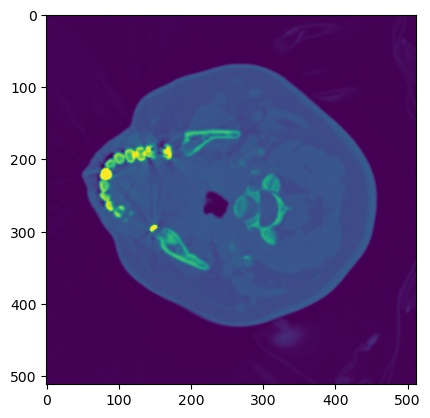

In [76]:
imshow(image[:,:,110])

In [77]:
car1filtered.max()

1679

In [78]:
car1filtered += car2filtered

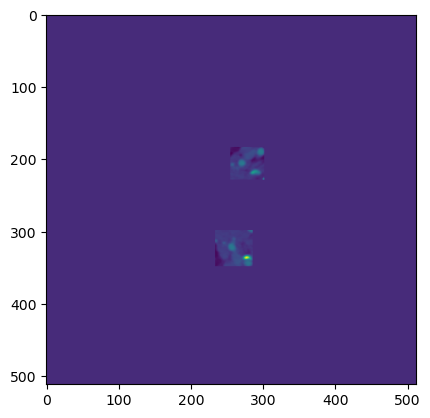

In [79]:
imshow(car1filtered[:,:,110])

In [80]:
test_image = car1filtered[:,:,104]

In [81]:
test_image_pred = model.predict(test_image.reshape(1,512,512,1))

In [82]:
test_image_pred.max()

0.002901844

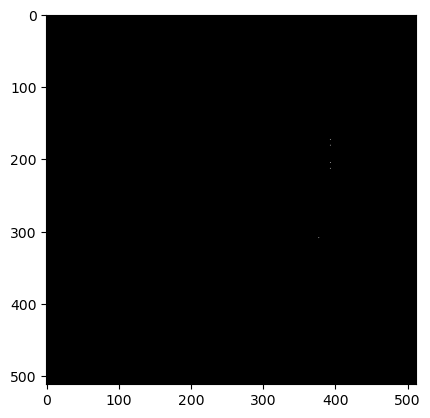

In [84]:
imshow(C.Util.binarize(test_image_pred[0,:,:,0], threshold=.0001),cmap = 'gray')

In [15]:
test_image_pred.astype

<function ndarray.astype>

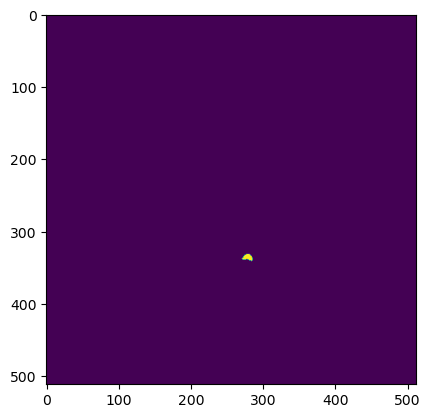

In [16]:
imshow(label[:,:,110])

In [93]:
import time

In [21]:
t0 = time.time()
image_pred = np.zeros(label.shape, label.dtype)

jaccard_per_slice = []

for z in range(image.shape[2]):
    
    cur_slice = image[:,:,z]
    
    cur_slice = C.Util.normalize(cur_slice)
    
    cur_slice_pred = model.predict(cur_slice.reshape(1,512,512,1))
    
    cur_slice_pred = C.Util.binarize(cur_slice_pred[0,:,:,0], threshold=.01)
    
    image_pred[:,:,z] = cur_slice_pred
    
    jac = C.Util.jaccard(C.Util.binarize(label[:,:,z]), cur_slice_pred)

    jaccard_per_slice.append(jac)
    
#     print('predicted', z)
print(time.time()-t0, 'seconds')

25.37657642364502 seconds


In [22]:
np.mean(jaccard_per_slice), np.std(jaccard_per_slice)

(0.19992897115947705, 0.38960950245422404)